## Importing the required libraries

In [146]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd
import warnings
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import soundfile as sf

In [147]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

In [148]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import pickle

In [149]:
warnings.filterwarnings('ignore')
%matplotlib inline

## Dataset Exploration & Visualisation of different audio wafeforms

The Genres present in the dataset

In [150]:
print("The genres present in the dataset are:")
print(os.listdir("Data/genres_original"))

The genres present in the dataset are:
['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


Understanding the audion files

In [151]:
y, sr = librosa.load("Data/genres_original/blues/blues.00000.wav")

print("Sound Array :", y)
print("Sample Rate (KHz) =", sr)

Sound Array : [ 0.00732422  0.01660156  0.00762939 ... -0.05560303 -0.06106567
 -0.06417847]
Sample Rate (KHz) = 22050


Trimming the Silence sequences in the audio files

In [152]:
y, _ = librosa.effects.trim(y)
print("After trimming the silence sequences the sound array is:")
print(y)

# Observe no preceeding or succeding silence

After trimming the silence sequences the sound array is:
[ 0.00732422  0.01660156  0.00762939 ... -0.05560303 -0.06106567
 -0.06417847]


2D Representation of audio using Waveform

Text(0.5, 1.0, 'Waveform in Blues 0')

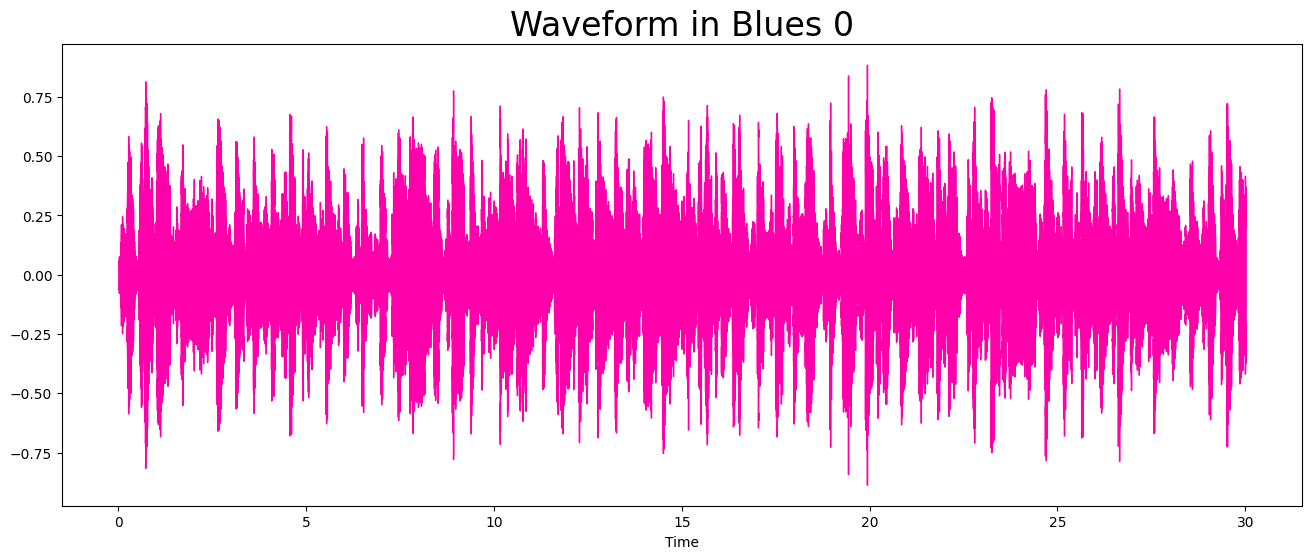

In [153]:
plt.figure(figsize = (16,6))
librosa.display.waveshow(y = y, sr = sr, color = "#FF00AB");
plt.title("Waveform in Blues 0", fontsize = 24)

Decomposing the waveform based on the frequencies using Short time Fouries Transform

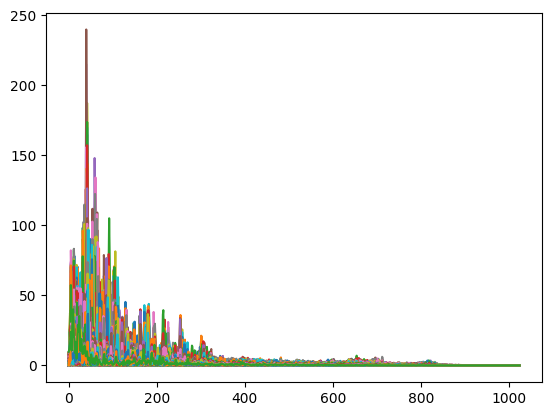

In [154]:
n_fft = 2048
hop_length = 512

D = np.abs(librosa.stft(y, n_fft = n_fft, hop_length = hop_length))

plt.plot(D)
plt.show()

Creating the Log Frequency Spectrogram from the transformed Signal

Text(0.5, 1.0, 'Log Frequency Spectrogram')

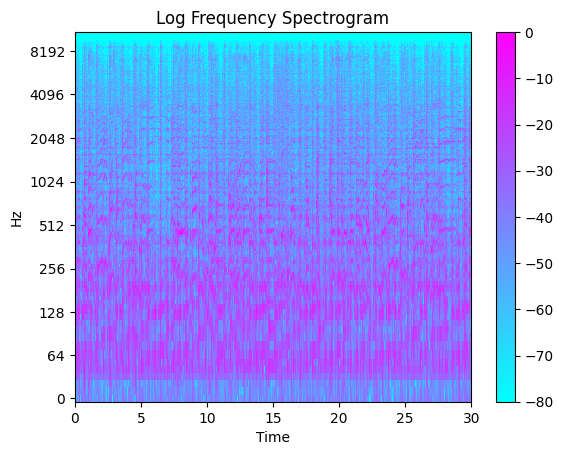

In [155]:
# This also scales to the decibel system, as that is also log based.

Deci = librosa.amplitude_to_db(D, ref = np.max)
librosa.display.specshow(Deci, sr = sr, hop_length=hop_length, x_axis='time',y_axis='log',cmap = 'cool')

plt.colorbar()
plt.title("Log Frequency Spectrogram")

Plotting Mel Spectrogram from the data

Text(0.5, 1.0, 'Mel Spectrogram')

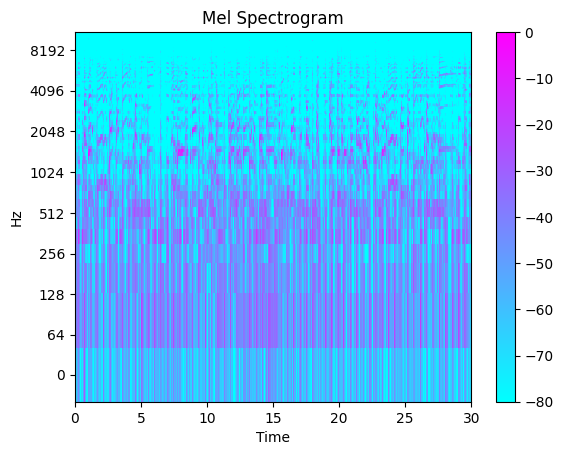

In [156]:
Mel_S = librosa.feature.melspectrogram(y =y, sr= sr)
Deci_S = librosa.amplitude_to_db(Mel_S, ref = np.max)
librosa.display.specshow(Deci_S, sr=sr, hop_length=hop_length, x_axis = 'time', y_axis = 'log',cmap = 'cool')
plt.colorbar()
plt.title("Mel Spectrogram", fontsize = 12)

Plotting Chroma Spectrogram which represents the energy distribution across pitch classes

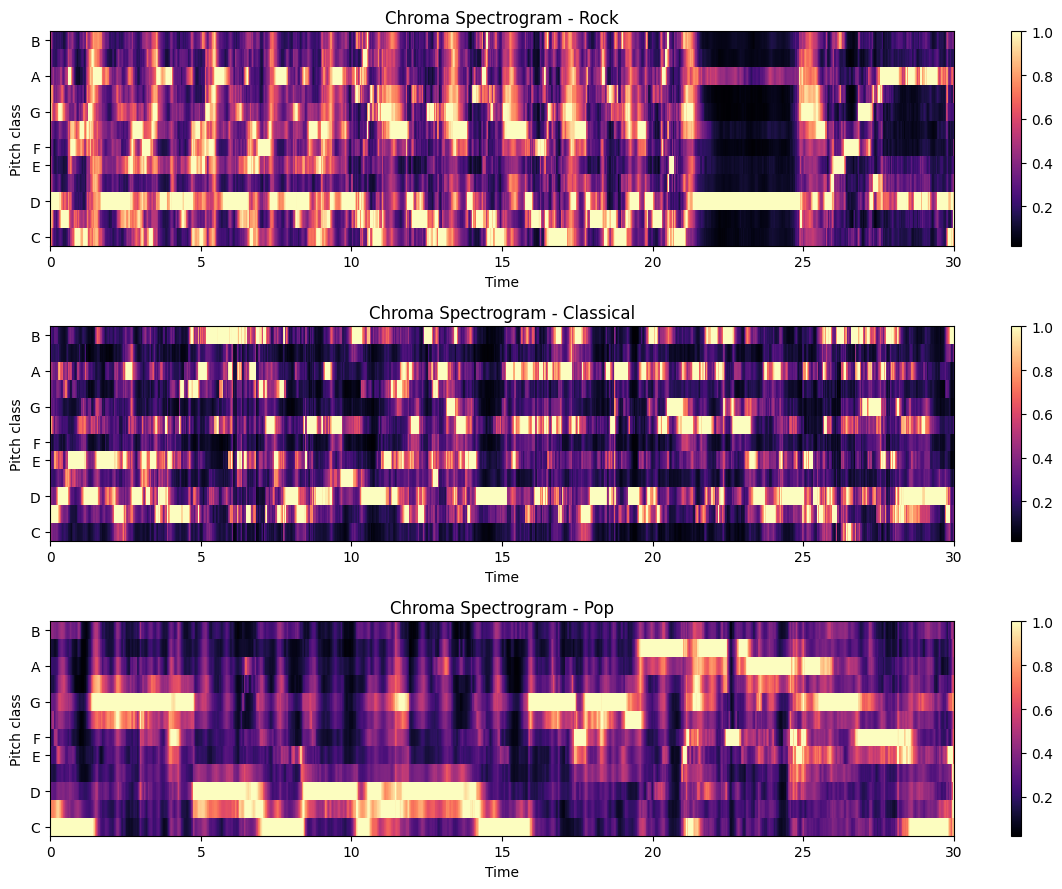

In [157]:
# Lets compare 3 genres, Rock, Pop and Classical

rock, r_sr = librosa.load("Data/genres_original/rock/rock.00000.wav")
classical, c_sr = librosa.load("Data/genres_original/classical/classical.00000.wav")
pop, p_sr = librosa.load("Data/genres_original/pop/pop.00000.wav")

# Compute chroma spectrograms for each genre
chroma_rock = librosa.feature.chroma_cqt(y=rock, sr=r_sr)
chroma_cls = librosa.feature.chroma_cqt(y=classical, sr=c_sr)
chroma_pop = librosa.feature.chroma_cqt(y=pop, sr=p_sr)

# Plot the chroma spectrograms for each genre
plt.figure(figsize=(12, 9))

plt.subplot(3, 1, 1)
librosa.display.specshow(chroma_rock, sr=r_sr, x_axis='time', y_axis='chroma')
plt.title('Chroma Spectrogram - Rock')
plt.colorbar()
plt.tight_layout()

plt.subplot(3, 1, 2)
librosa.display.specshow(chroma_cls, sr=c_sr, x_axis='time', y_axis='chroma')
plt.title('Chroma Spectrogram - Classical')
plt.colorbar()
plt.tight_layout()

plt.subplot(3, 1, 3)
librosa.display.specshow(chroma_pop, sr=p_sr, x_axis='time', y_axis='chroma')
plt.title('Chroma Spectrogram - Pop')
plt.colorbar()
plt.tight_layout()

plt.show()

As can be seen through the chroma spectogram, the Rock and Classical Music seem to have the melodies consisting to a lot of notes at the same time, while the pop music(for general audience) consist very few notes at the same instant.
Even if multiple notes are present at same time in Pop, they are usually harmonies i.e. 3rd or 5th of the root note.

Plotting Tempograms for a few genres

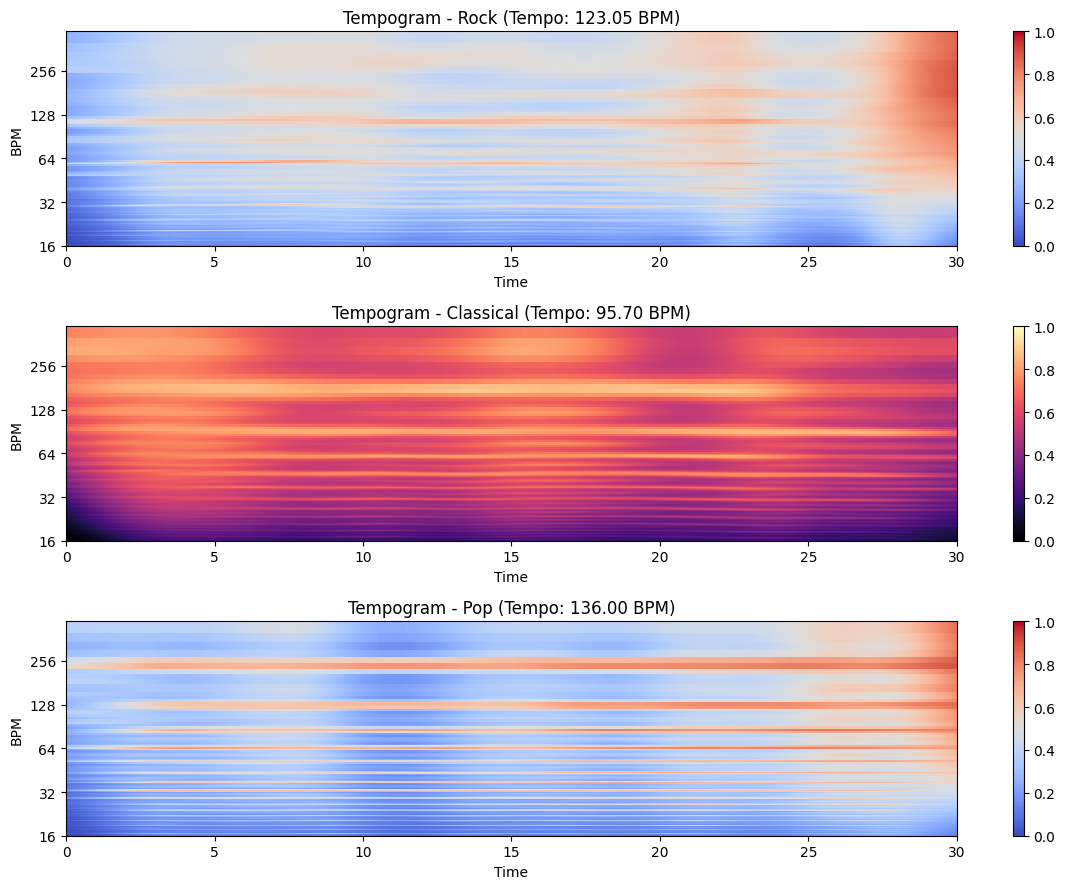

In [158]:
tempo_rock= librosa.beat.tempo(y=rock, sr=r_sr)
tempogram_rock = librosa.feature.tempogram(y=rock, sr=r_sr, hop_length=512, win_length=384, window=np.hanning)

tempo_cls = librosa.beat.tempo(y=classical, sr=c_sr)
tempogram_cls = librosa.feature.tempogram(y=classical, sr=c_sr, hop_length=512, win_length=384, window=np.hanning)

tempo_pop = librosa.beat.tempo(y=pop, sr=p_sr)
tempogram_pop = librosa.feature.tempogram(y=pop, sr=p_sr, hop_length=512, win_length=384, window=np.hanning)

# Plot the tempograms for each genre
plt.figure(figsize=(12, 9))

plt.subplot(3, 1, 1)
librosa.display.specshow(tempogram_rock, sr=r_sr, hop_length=512, x_axis='time', y_axis='tempo')
plt.title('Tempogram - Rock (Tempo: {:.2f} BPM)'.format(tempo_rock[0]))
plt.colorbar()
plt.tight_layout()

plt.subplot(3, 1, 2)
librosa.display.specshow(tempogram_cls, sr=c_sr, hop_length=512, x_axis='time', y_axis='tempo')
plt.title('Tempogram - Classical (Tempo: {:.2f} BPM)'.format(tempo_cls[0]))
plt.colorbar()
plt.tight_layout()

plt.subplot(3, 1, 3)
librosa.display.specshow(tempogram_pop, sr=p_sr, hop_length=512, x_axis='time', y_axis='tempo')
plt.title('Tempogram - Pop (Tempo: {:.2f} BPM)'.format(tempo_pop[0]))
plt.colorbar()
plt.tight_layout()

plt.show()

Not much can be said able the genres with just looking at the tempograms,
so let's overlay the tempogram with the CQT spectogram, which provides the pitch over time for the audio file.

Plotting CQT Spectrograms for a few genres

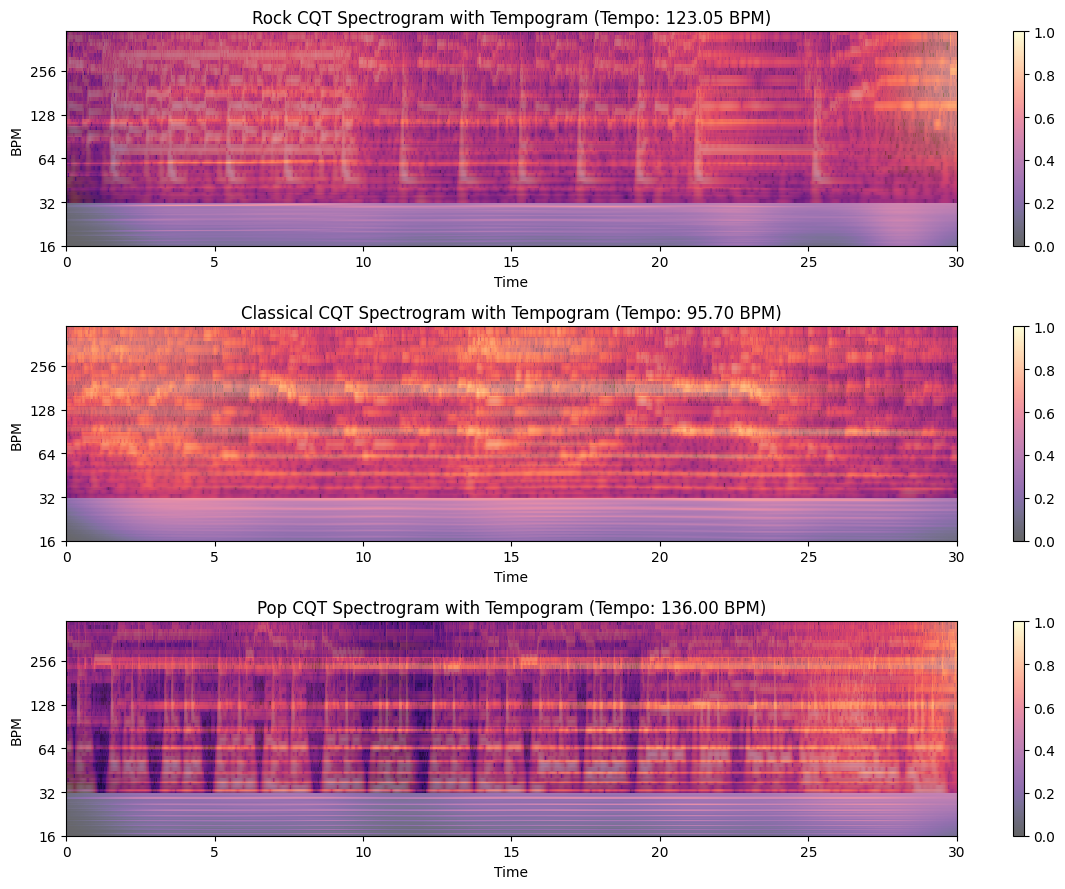

In [159]:
cqt_rock = np.abs(librosa.cqt(rock, sr=r_sr, hop_length=512))
cqt_cls = np.abs(librosa.cqt(classical, sr=c_sr, hop_length=512))
cqt_pop = np.abs(librosa.cqt(pop, sr=p_sr, hop_length=512))

# Plot the CQT spectrograms with tempograms overlaid for each genre
plt.figure(figsize=(12, 9))

plt.subplot(3, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(cqt_rock, ref=np.max), sr=r_sr, hop_length=512, x_axis='time', y_axis='cqt_note')
librosa.display.specshow(tempogram_rock, sr=r_sr, hop_length=512, x_axis='time', y_axis='tempo', cmap='magma', alpha=0.6)
plt.title('Rock CQT Spectrogram with Tempogram (Tempo: {:.2f} BPM)'.format(tempo_rock[0]))
plt.colorbar()
plt.tight_layout()

plt.subplot(3, 1, 2)
librosa.display.specshow(librosa.amplitude_to_db(cqt_cls, ref=np.max), sr=c_sr, hop_length=512, x_axis='time', y_axis='cqt_note')
librosa.display.specshow(tempogram_cls, sr=c_sr, hop_length=512, x_axis='time', y_axis='tempo', cmap='magma', alpha=0.6)
plt.title('Classical CQT Spectrogram with Tempogram (Tempo: {:.2f} BPM)'.format(tempo_cls[0]))
plt.colorbar()
plt.tight_layout()

plt.subplot(3, 1, 3)
librosa.display.specshow(librosa.amplitude_to_db(cqt_pop, ref=np.max), sr=p_sr, hop_length=512, x_axis='time', y_axis='cqt_note')
librosa.display.specshow(tempogram_pop, sr=p_sr, hop_length=512, x_axis='time', y_axis='tempo', cmap='magma', alpha=0.6)
plt.title('Pop CQT Spectrogram with Tempogram (Tempo: {:.2f} BPM)'.format(tempo_pop[0]))
plt.colorbar()
plt.tight_layout()

plt.show()


Harmonics & Percussive for the audio files

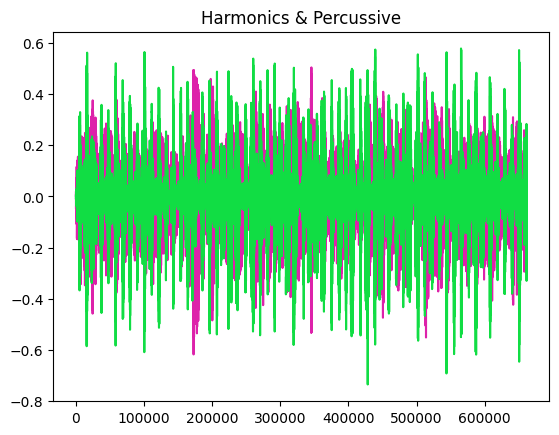

In [160]:
y_harm, y_perc = librosa.effects.hpss(y)
plt.plot(y_harm, color = '#DD22AA')
plt.plot(y_perc, color = '#11DD44')
plt.title("Harmonics & Percussive")
plt.show()

In [161]:
data = pd.read_csv("Data/features_3_sec.csv")
print(data.shape)

(9990, 60)


## Exploratory Data Analysis

Having a look at the data & the information about its features

In [162]:
data.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [163]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9990 entries, 0 to 9989
Data columns (total 60 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   filename                 9990 non-null   object 
 1   length                   9990 non-null   int64  
 2   chroma_stft_mean         9990 non-null   float64
 3   chroma_stft_var          9990 non-null   float64
 4   rms_mean                 9990 non-null   float64
 5   rms_var                  9990 non-null   float64
 6   spectral_centroid_mean   9990 non-null   float64
 7   spectral_centroid_var    9990 non-null   float64
 8   spectral_bandwidth_mean  9990 non-null   float64
 9   spectral_bandwidth_var   9990 non-null   float64
 10  rolloff_mean             9990 non-null   float64
 11  rolloff_var              9990 non-null   float64
 12  zero_crossing_rate_mean  9990 non-null   float64
 13  zero_crossing_rate_var   9990 non-null   float64
 14  harmony_mean            

In [164]:
data.describe()

,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
count,9990.0,9990.000000,9990.000000,9990.000000,9.990000e+03,9990.000000,9.990000e+03,9990.000000,9.990000e+03,9990.000000,...,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000
mean,66149.0,0.379534,0.084876,0.130859,2.676388e-03,2199.219431,4.166727e+05,2241.385959,1.182711e+05,4566.076592,...,1.448240,49.988755,-4.198706,51.962753,0.739943,52.488851,-2.497306,54.973829,-0.917584,57.322614
std,0.0,0.090466,0.009637,0.068545,3.585628e-03,751.860611,4.349644e+05,543.854449,1.013505e+05,1642.065335,...,5.735149,34.442816,5.677379,36.400669,5.181313,38.177120,5.111799,41.585677,5.253243,46.444212
min,66149.0,0.107108,0.015345,0.000953,4.379535e-08,472.741636,8.118813e+02,499.162910,1.183520e+03,658.336276,...,-26.850016,1.325786,-27.809795,1.624544,-20.733809,3.437439,-27.448456,3.065302,-35.640659,0.282131
25%,66149.0,0.315698,0.079833,0.083782,6.145900e-04,1630.680158,1.231961e+05,1887.455790,4.876553e+04,3378.311110,...,-2.227478,29.584894,-7.951722,29.863448,-2.516638,29.636197,-5.734123,30.496412,-4.004475,30.011365
50%,66149.0,0.384741,0.085108,0.121253,1.491318e-03,2208.628236,2.650692e+05,2230.575595,8.996072e+04,4631.377892,...,1.461623,41.702393,-4.443021,42.393583,0.733772,41.831377,-2.702366,43.435253,-1.030939,44.332155
75%,66149.0,0.442443,0.091092,0.176328,3.130862e-03,2712.581884,5.624152e+05,2588.340505,1.585674e+05,5591.634521,...,5.149752,59.274619,-0.726945,61.676964,3.888734,62.033906,0.514246,65.328602,2.216603,68.210421
max,66149.0,0.749481,0.120964,0.442567,3.261522e-02,5432.534406,4.794119e+06,3708.147554,1.235143e+06,9487.446477,...,39.144405,683.932556,34.048843,529.363342,36.970322,629.729797,31.365425,1143.230591,34.212101,910.473206


#### Box Plot

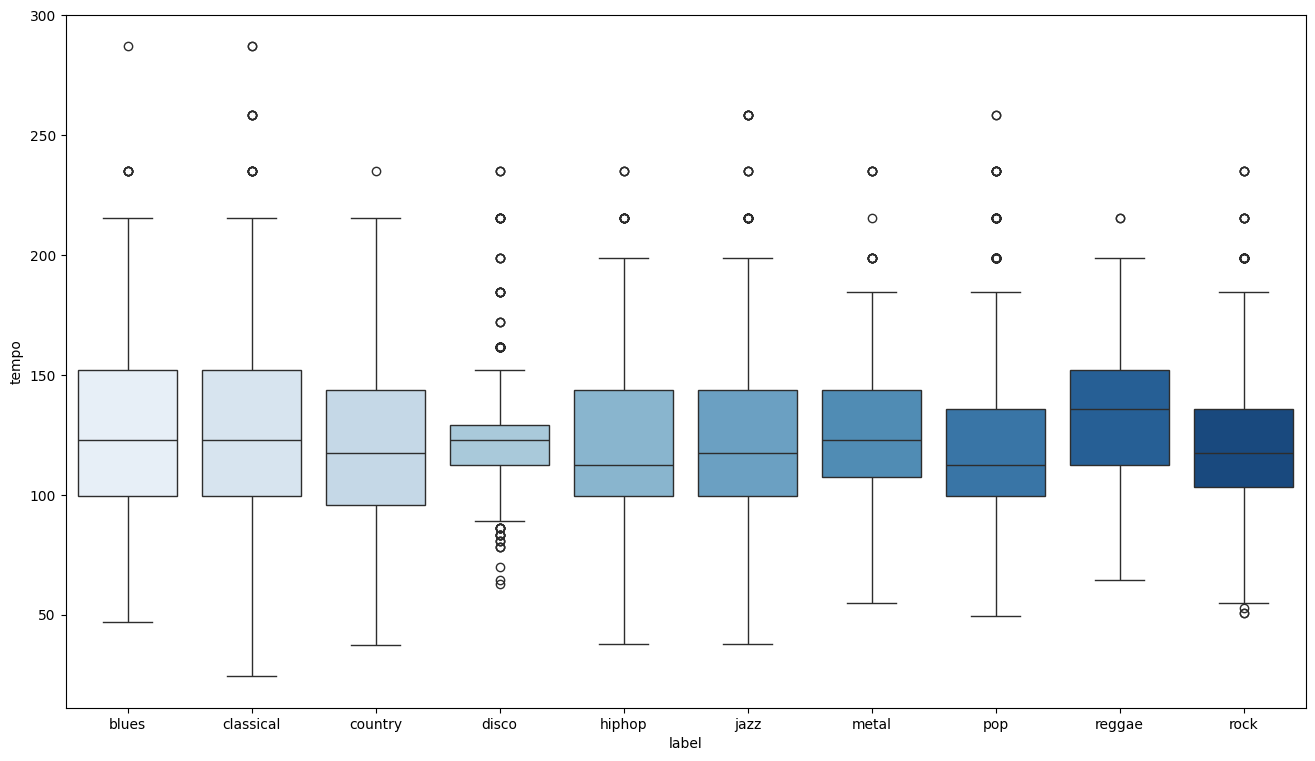

In [165]:
# Box plot of label vs tempo
x = data[["label", "tempo"]]

f, ax = plt.subplots(figsize=(16, 9));
sns.boxplot(x = "label", y = "tempo", data = x, palette = 'Blues')

plt.show()

#### CorrelationHeatmap

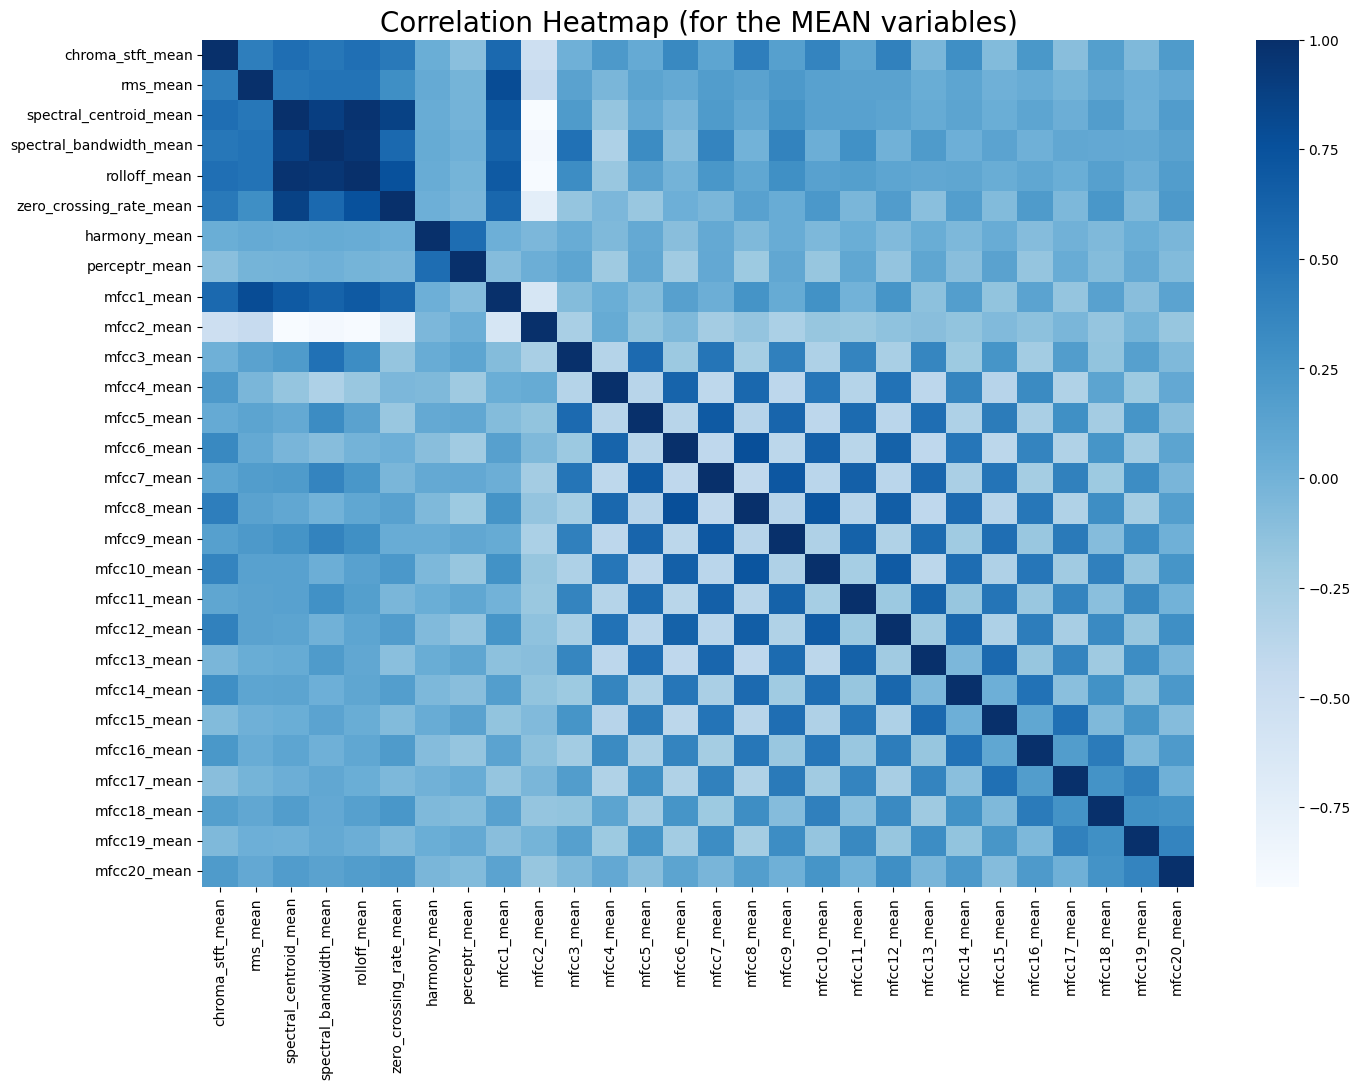

In [166]:
# Heat map for the mean variables
mean_cols = [col for col in data.columns if 'mean' in col]

corr = data[mean_cols].corr()
f, ax = plt.subplots(figsize=(16, 11))

sns.heatmap(corr, cmap = 'Blues')
plt.title('Correlation Heatmap (for the MEAN variables)', fontsize = 20)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)

plt.show()

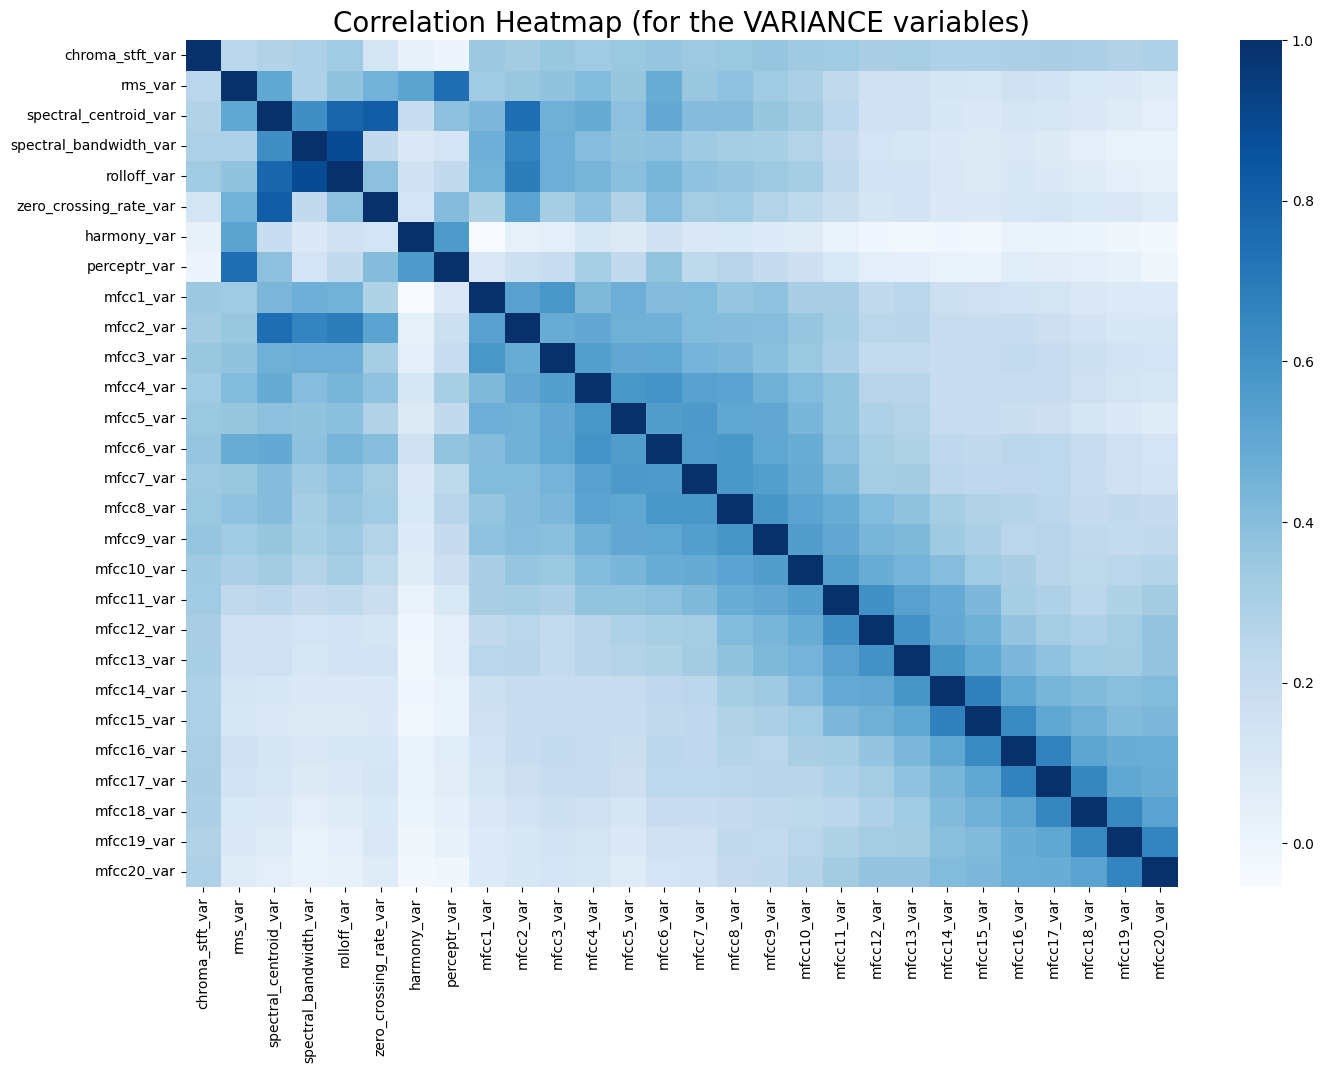

In [167]:
# Heat map for Variance variables
var_cols = [col for col in data.columns if 'var' in col]

corr = data[var_cols].corr()
f, ax = plt.subplots(figsize=(16, 11))

sns.heatmap(corr, cmap = 'Blues')
plt.title('Correlation Heatmap (for the VARIANCE variables)', fontsize = 20)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)

plt.show()

## Preprocessing

In [168]:
data.drop(['filename','length'], axis = 1, inplace = True)

In [169]:
data.head()

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,3714.560359,1.080790e+06,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,3869.682242,6.722448e+05,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,3997.639160,7.907127e+05,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,3568.300218,9.216524e+05,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,3469.992864,6.102111e+05,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [170]:
X = data.iloc[:,:-1]

In [171]:
Y = data.iloc[:,-1]

In [172]:
Y

0       blues
1       blues
2       blues
3       blues
4       blues
        ...  
9985     rock
9986     rock
9987     rock
9988     rock
9989     rock
Name: label, Length: 9990, dtype: object

#### Scaling the features of data

In [173]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(X)

In [174]:
columns = X.columns

In [175]:
X_scaled = pd.DataFrame(scaled_data, columns = columns)

In [176]:
X_scaled.head()

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,0.355399,0.716757,0.293133,0.107955,0.262173,0.034784,0.459205,0.094130,0.346153,0.083164,...,0.363613,0.056198,0.397172,0.066062,0.371828,0.055344,0.380831,0.026797,0.506746,0.047781
1,0.367322,0.670347,0.253040,0.044447,0.270969,0.018716,0.470831,0.052261,0.363722,0.051694,...,0.468596,0.092912,0.351681,0.074001,0.362068,0.076365,0.418452,0.082414,0.593029,0.065548
2,0.373159,0.728067,0.296753,0.141663,0.265293,0.023073,0.494051,0.059922,0.378215,0.060820,...,0.479681,0.096704,0.420979,0.050639,0.400536,0.067509,0.433742,0.043841,0.546264,0.036062
3,0.399349,0.677066,0.298024,0.075042,0.238427,0.023187,0.455246,0.066234,0.329587,0.070906,...,0.386258,0.067995,0.387474,0.050617,0.380430,0.050030,0.405824,0.041898,0.562204,0.034873
4,0.355668,0.689113,0.322308,0.052149,0.233460,0.016451,0.451651,0.047830,0.318453,0.046916,...,0.438567,0.042500,0.460314,0.083860,0.388590,0.076524,0.409019,0.020763,0.517913,0.031713


#### Implementing Principal Component Analysis

Checking the Variance explained by different number of components

In [177]:
for i in range(1,57):
    pca_dummy = PCA(n_components = i)

    dummy_trans = pca_dummy.fit_transform(X_scaled)

    print("For", i,"number of components Explained Variance Ratio =", pca_dummy.explained_variance_ratio_.cumsum()[i-1])

For 1 number of components Explained Variance Ratio = 0.26745621154231103
For 2 number of components Explained Variance Ratio = 0.44983624401319355
For 3 number of components Explained Variance Ratio = 0.5307729242137342
For 4 number of components Explained Variance Ratio = 0.5880377921848291
For 5 number of components Explained Variance Ratio = 0.6380888840546086
For 6 number of components Explained Variance Ratio = 0.6777285215675819
For 7 number of components Explained Variance Ratio = 0.7058161419081866
For 8 number of components Explained Variance Ratio = 0.7316676302683729
For 9 number of components Explained Variance Ratio = 0.7525273823873048
For 10 number of components Explained Variance Ratio = 0.7708273971645242
For 11 number of components Explained Variance Ratio = 0.7860644712339223
For 12 number of components Explained Variance Ratio = 0.8006122588317978
For 13 number of components Explained Variance Ratio = 0.8135605220501899
For 14 number of components Explained Varianc

Since, 90% of the variance can be explained by taking 24 components so, the components are reduced to 24

In [178]:
# 90% of variance can be explained using 24 components
pca = PCA(n_components = 24)
components = pca.fit_transform(X_scaled)

X_pca = pd.DataFrame(components)

Splitting the reduced data in train & test part

In [179]:
X_train, X_test, y_train, y_test = train_test_split(X_pca,Y, test_size=0.2, random_state=30)

In [180]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
3464,-0.572951,0.201434,-0.115938,0.239000,0.067305,-0.081847,-0.046196,-0.012496,0.137080,0.256488,...,-0.088937,0.026924,-0.062402,0.074612,0.003156,0.041057,-0.003614,0.032632,0.029104,-0.130115
8204,-0.157563,-0.215466,0.081860,0.048265,0.101968,-0.004883,-0.022902,0.108854,0.027427,0.165542,...,-0.037261,-0.065343,-0.057013,0.021204,0.143576,-0.007054,-0.020067,-0.015440,-0.003516,0.070943
2420,0.122325,0.149607,-0.227326,-0.005400,-0.043762,-0.243890,0.033656,-0.061202,-0.207401,-0.131804,...,0.027571,0.017629,-0.013660,-0.039873,-0.040058,0.028479,0.084210,-0.044195,0.024140,-0.056104
9438,-0.147923,0.390750,-0.274402,-0.206364,0.160324,0.001109,-0.208738,-0.132174,0.334593,0.285462,...,-0.073879,0.100042,-0.047279,-0.000673,-0.007099,-0.138247,0.081367,0.052122,-0.025998,-0.015219
5079,-0.329471,0.173976,0.158813,-0.371490,-0.074479,0.039211,0.074447,-0.075000,0.092056,0.048517,...,0.017222,-0.054383,0.003918,0.045741,-0.084324,0.068196,-0.024063,-0.059481,-0.005069,0.123669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4859,-0.045763,-0.191241,0.071870,-0.043077,-0.227238,0.251084,-0.115592,-0.082380,0.004678,-0.013738,...,-0.029255,0.143318,-0.011352,0.088647,0.094447,-0.054405,-0.027049,-0.076452,0.063200,0.031381
919,-0.407303,0.067559,-0.035861,-0.175826,-0.011658,0.019907,0.116416,0.009987,0.075483,0.114617,...,-0.018350,0.081660,0.040590,0.051401,-0.007358,-0.018059,-0.000788,-0.020332,0.027330,-0.043278
500,-0.126057,-0.345201,-0.021587,-0.180417,-0.000472,-0.086998,-0.179243,0.068230,-0.041321,0.060654,...,0.051216,-0.075931,-0.031431,0.071288,0.032674,-0.049717,-0.035420,0.026429,0.033649,-0.050664
4517,0.288444,0.159433,-0.239582,-0.197313,-0.308334,-0.057465,-0.021569,-0.099972,0.090034,-0.061655,...,-0.044386,-0.007758,0.038936,-0.037138,-0.040489,0.029989,0.058033,-0.052889,0.034438,-0.061446


## Implementing different models

#### Implementing K Nearest Neighbors

Grid Search for finding best parameters for K Nearest Neighbors

In [181]:
# Setting up the parameter grid for KNN
param_found_knn = 1

knn_params = {
    'n_neighbors': range(1, 21),  # Considering a range that isn't too broad
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']  # Adding different distance metrics
}
knn_grid = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5, scoring='accuracy', verbose=1)

if not param_found_knn:
    knn_grid.fit(X_train, y_train)

    # Best parameters and best score
    print("Best parameters for KNN:", knn_grid.best_params_)
    print("Best cross-validation score for KNN:", knn_grid.best_score_)

else:
    knn_grid.best_params_ = {'metric': 'manhattan', 'n_neighbors': 4, 'weights': 'distance'}


Best parameters for KNN: {'metric': 'manhattan', 'n_neighbors': 4, 'weights': 'distance'}

In [182]:
# Training KNN with the best parameters
knn_best = KNeighborsClassifier(**knn_grid.best_params_)
knn_best.fit(X_train, y_train)
y_pred_knn_test = knn_best.predict(X_test)
y_pred_knn_train = knn_best.predict(X_train)

# Evaluation
knn_accuracy_test = accuracy_score(y_test, y_pred_knn_test)
knn_accuracy_train = accuracy_score(y_train, y_pred_knn_train)
knn_report = classification_report(y_test, y_pred_knn_test, output_dict=True)
print("Accuracy using KNN =", knn_accuracy_test)

Accuracy using KNN = 0.913913913913914


Classfication Report for K Nearest Neighbors

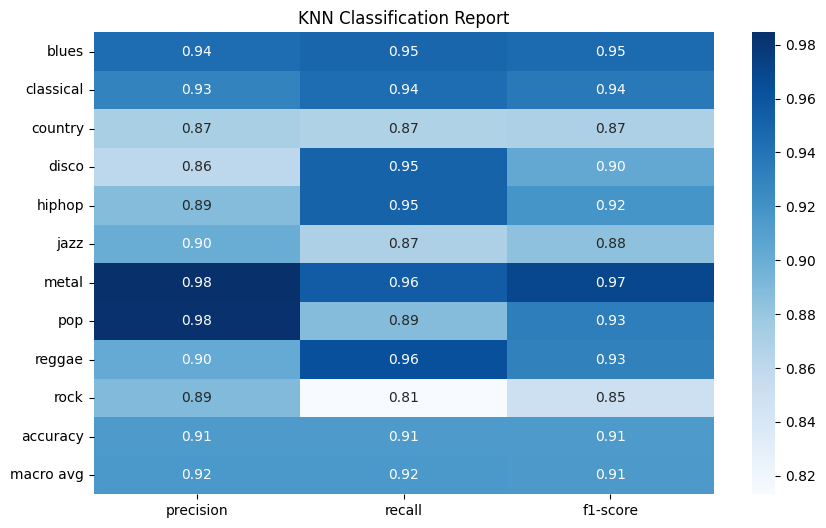

In [183]:
# Transform classification report into DataFrame
knn_report_df = pd.DataFrame(knn_report).transpose()

# Plotting the classification report
plt.figure(figsize=(10, 6))
sns.heatmap(data=knn_report_df.iloc[:-1, :].drop(columns=['support']), annot=True, cmap='Blues', fmt='.2f')
plt.title('KNN Classification Report')
plt.show()

Confusion Matrix for K Nearest Neighbors

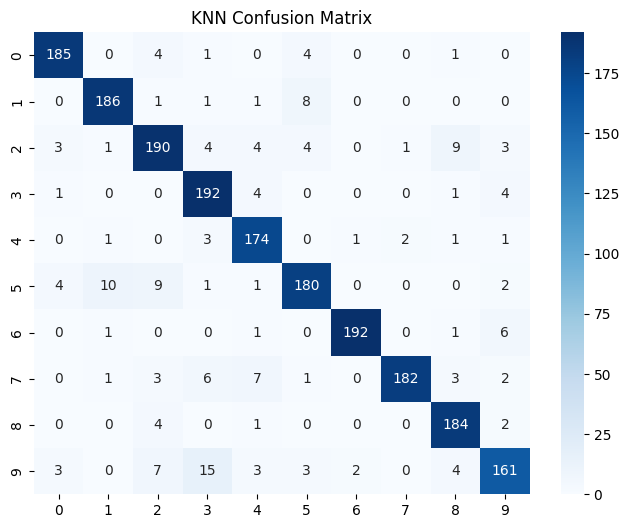

In [184]:
# Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_knn_test), annot=True, fmt='d', cmap='Blues')
plt.title('KNN Confusion Matrix')
plt.show()

#### Implementing Decision Trees

Grid Search for finding best parameters for Decision Trees

In [185]:
# Setting up the parameter grid for Decision Trees

param_found_dt = 1
dt_params = {
    'max_depth': range(5, 10),  # Max depth to prevent overfitting
    'min_samples_split': range(2, 10, 2),  # Moderate range for minimum samples split
    'min_samples_leaf': range(1, 5)  # Minimum samples per leaf to ensure generalization
}
dt_grid = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_params, cv=5, scoring='accuracy', verbose=1)

if not param_found_dt:
    dt_grid.fit(X_train, y_train)

    # Best parameters and best score
    print("Best parameters for Decision Tree:", dt_grid.best_params_)
    print("Best cross-validation score for Decision Tree:", dt_grid.best_score_)

else:
    dt_grid.best_params_ = {'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 4}

Best parameters for Decision Tree: {'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 4}

In [186]:
# Training Decision Tree with the best parameters
dt_best = DecisionTreeClassifier(**dt_grid.best_params_, random_state=42)
dt_best.fit(X_train, y_train)
y_pred_dt_test = dt_best.predict(X_test)
y_pred_dt_train = dt_best.predict(X_train)

# Evaluation
dt_accuracy_test = accuracy_score(y_test, y_pred_dt_test)
dt_accuracy_train = accuracy_score(y_train, y_pred_dt_train)
dt_report = classification_report(y_test, y_pred_dt_test, output_dict=True)
print("Accuracy using Decision Tree =", dt_accuracy_test)

Accuracy using Decision Tree = 0.5730730730730731


Classification Report for Decision Trees

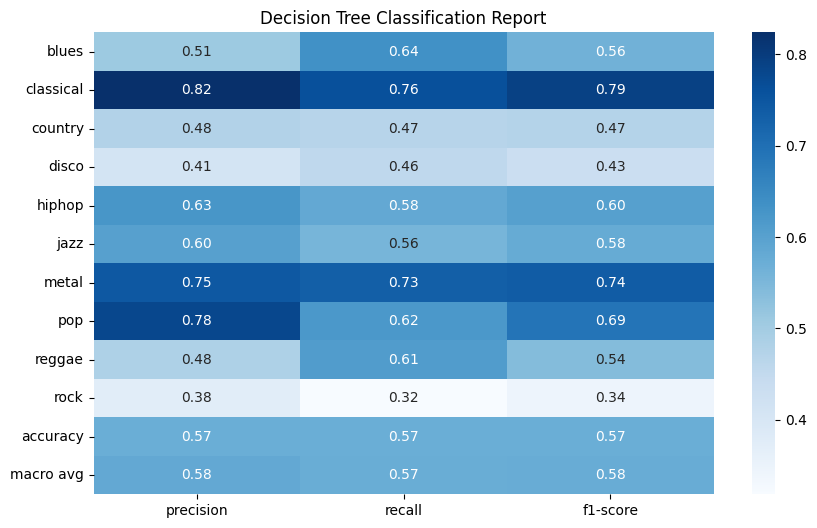

In [187]:
# Transform classification report into DataFrame
dt_report_df = pd.DataFrame(dt_report).transpose()

# Plotting the classification report
plt.figure(figsize=(10, 6))
sns.heatmap(data=dt_report_df.iloc[:-1, :].drop(columns=['support']), annot=True, cmap='Blues', fmt='.2f')
plt.title('Decision Tree Classification Report')
plt.show()


Confusion Matrix for Decision Trees

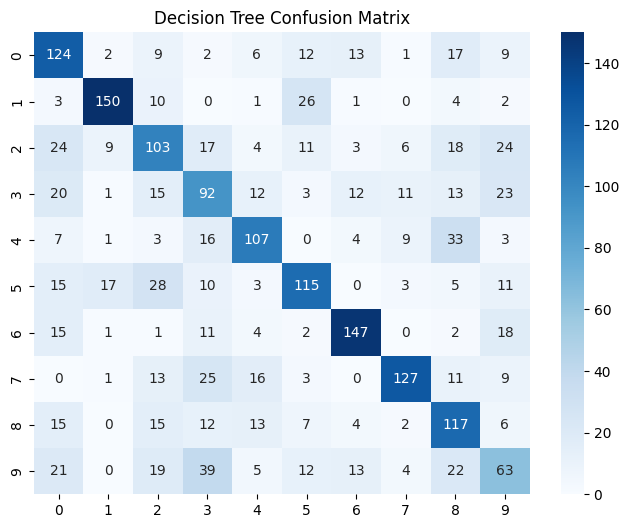

In [188]:
# Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_dt_test), annot=True, fmt='d', cmap='Blues')
plt.title('Decision Tree Confusion Matrix')
plt.show()

#### Implementing Support Vector Machines

Grid Search for finding best parameters for Support Vector Machines

In [189]:
# Setting up the parameter grid for SVM

param_found_svm = 1
svm_params = {
    'C': [0.1, 1, 10],  # Regularization parameter
    'gamma': ['scale', 'auto'],  # Kernel coefficient
    'kernel': ['rbf', 'poly', 'sigmoid']  # Different types of kernels
}
svm_grid = GridSearchCV(SVC(random_state=42), svm_params, cv=5, scoring='accuracy', verbose=1)
if not param_found_svm:

    svm_grid.fit(X_train, y_train)

    # Best parameters and best score
    print("Best parameters for SVM:", svm_grid.best_params_)
    print("Best cross-validation score for SVM:", svm_grid.best_score_)

else:
    svm_grid.best_params_ = {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


Best parameters for SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

In [190]:
# Training SVM with the best parameters
svm_best = SVC(**svm_grid.best_params_, random_state=42)
svm_best.fit(X_train, y_train)
y_pred_svm_test = svm_best.predict(X_test)
y_pred_svm_train = svm_best.predict(X_train)

# Evaluation
svm_accuracy_test = accuracy_score(y_test, y_pred_svm_test)
svm_accuracy_train = accuracy_score(y_train, y_pred_svm_train)
svm_report = classification_report(y_test, y_pred_svm_test, output_dict=True)

print("Accuracy using SVM =", svm_accuracy_test)

Accuracy using SVM = 0.8978978978978979


Classification Report for Support Vector Machines

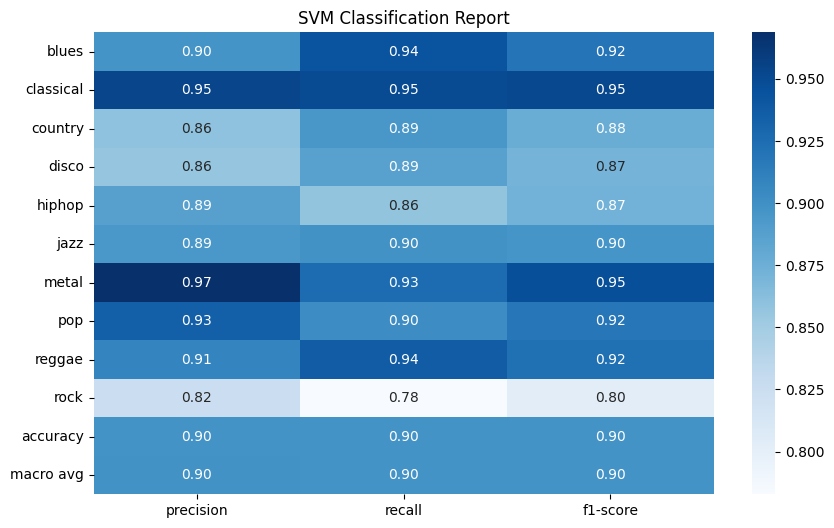

In [191]:
# Transform classification report into DataFrame
svm_report_df = pd.DataFrame(svm_report).transpose()

# Plotting the classification report
plt.figure(figsize=(10, 6))
sns.heatmap(data=svm_report_df.iloc[:-1, :].drop(columns=['support']), annot=True, cmap='Blues', fmt='.2f')
plt.title('SVM Classification Report')
plt.show()


Confusion Matrix for Support Vector Machines

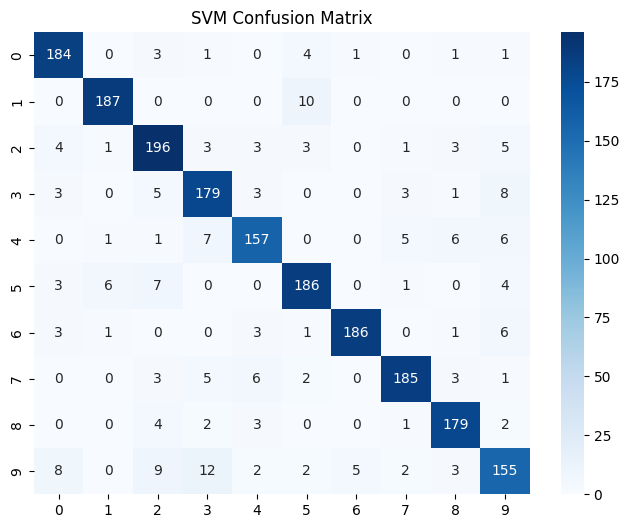

In [192]:
# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_svm_test), annot=True, fmt='d', cmap='Blues')
plt.title('SVM Confusion Matrix')
plt.show()

#### Implementing Adaboost

Grid Search for finding best parameters for Adaboost

In [193]:
param_found_ada = 1
adaboost_params = {
    'n_estimators': [50, 100, 150, 200], # Number of models to iteratively train
    'learning_rate': [0.01, 0.05, 0.1, 0.5, 1] # Weight applied to each classifier at each boosting iteration
}
adaboost_grid = GridSearchCV(AdaBoostClassifier(random_state=42), adaboost_params, cv=5, scoring='accuracy', verbose=1)
if not param_found_ada:
# Setting up the parameter grid for Adaboost

    adaboost_grid.fit(X_train, y_train)

    # Best parameters and best score
    print("Best parameters for Adaboost:", adaboost_grid.best_params_)
    print("Best cross-validation score for Adaboost:", adaboost_grid.best_score_)
else:
    adaboost_grid.best_params_ = {'learning_rate': 0.5, 'n_estimators': 50}

Best parameters for Adaboost: {'learning_rate': 0.5, 'n_estimators': 50}

In [194]:
# Training Adaboost with the best parameters
adaboost_best = AdaBoostClassifier(**adaboost_grid.best_params_, random_state=42)
adaboost_best.fit(X_train, y_train)
y_pred_adaboost_test = adaboost_best.predict(X_test)
y_pred_adaboost_train = adaboost_best.predict(X_train)

# Evaluation
adaboost_accuracy_test = accuracy_score(y_test, y_pred_adaboost_test)
adaboost_accuracy_train = accuracy_score(y_train, y_pred_adaboost_train)
adaboost_report = classification_report(y_test, y_pred_adaboost_test, output_dict=True)

print("Accuracy using Adaboost =", adaboost_accuracy_test)

Accuracy using Adaboost = 0.3638638638638639


Classification Report for Adaboost

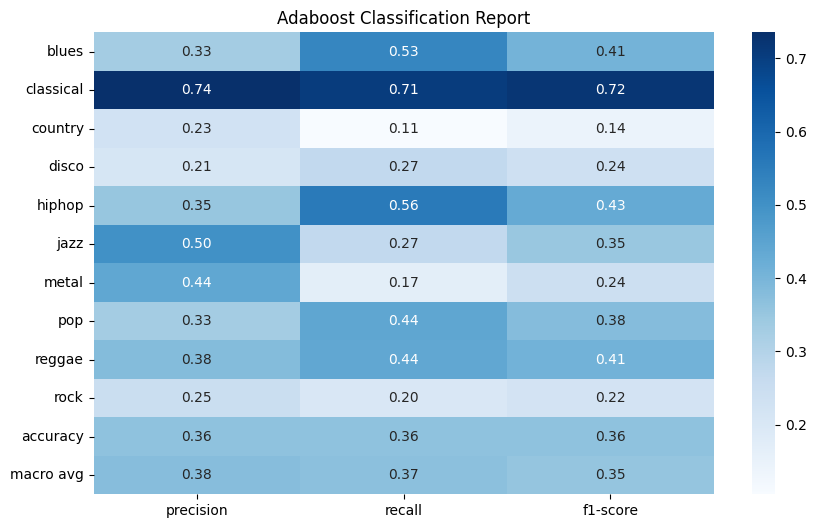

In [195]:
# Transform classification report into DataFrame
adaboost_report_df = pd.DataFrame(adaboost_report).transpose()

# Plotting the classification report
plt.figure(figsize=(10, 6))
sns.heatmap(data=adaboost_report_df.iloc[:-1, :].drop(columns=['support']), annot=True, cmap='Blues', fmt='.2f')
plt.title('Adaboost Classification Report')
plt.show()

Confusion Matrix for Adaboost

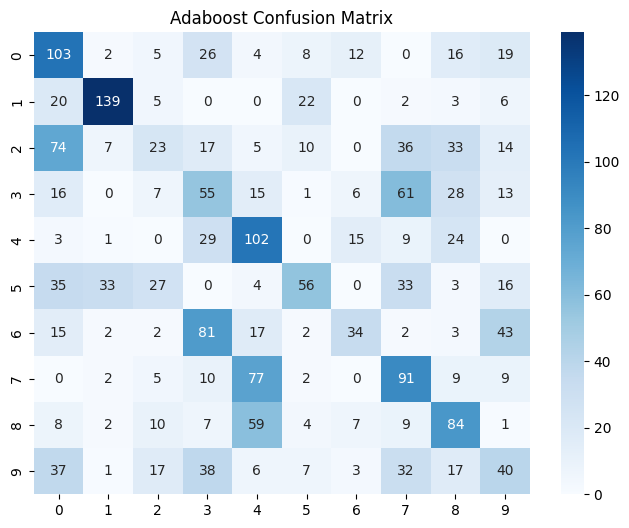

In [196]:
# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_adaboost_test), annot=True, fmt='d', cmap='Blues')
plt.title('Adaboost Confusion Matrix')
plt.show()

#### Implementing Logistic Regression

Grid Search for finding best parameters for Logistic Regression

In [197]:
# Setting up the parameter grid for Logistic Regression
param_found_lr = 1

lr_params = {
    'C': [0.1, 1, 10, 100],  # Inverse of regularization strength
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],  # Algorithm to use in the optimization problem
    'max_iter': [100, 200, 300]  # Maximum number of iterations taken for the solvers to converge
}
lr_grid = GridSearchCV(LogisticRegression(random_state=42), lr_params, cv=5)

if not param_found_ada:
    lr_grid.fit(X_train, y_train)

    # Best parameters and best score
    print("Best parameters for Logistic Regression:", lr_grid.best_params_)
    print("Best cross-validation score for Logistic Regression:", lr_grid.best_score_)

else:
    lr_grid.best_params_= {'C': 100, 'max_iter': 100, 'solver': 'lbfgs'}


Best parameters for Logistic Regression: {'C': 100, 'max_iter': 100, 'solver': 'lbfgs'}

In [198]:
# Training Logistic Regression with the best parameters
lr_best = LogisticRegression(**lr_grid.best_params_, random_state=42)
lr_best.fit(X_train, y_train)
y_pred_lr_test = lr_best.predict(X_test)
y_pred_lr_train = lr_best.predict(X_train)

# Evaluation
lr_accuracy_test = accuracy_score(y_test, y_pred_lr_test)
lr_accuracy_train = accuracy_score(y_train, y_pred_lr_train)
lr_report = classification_report(y_test, y_pred_lr_test, output_dict=True)

print("Accuracy using Logistic Regression =", lr_accuracy_test)

Accuracy using Logistic Regression = 0.6661661661661662


Classification Report for Logistic Regression

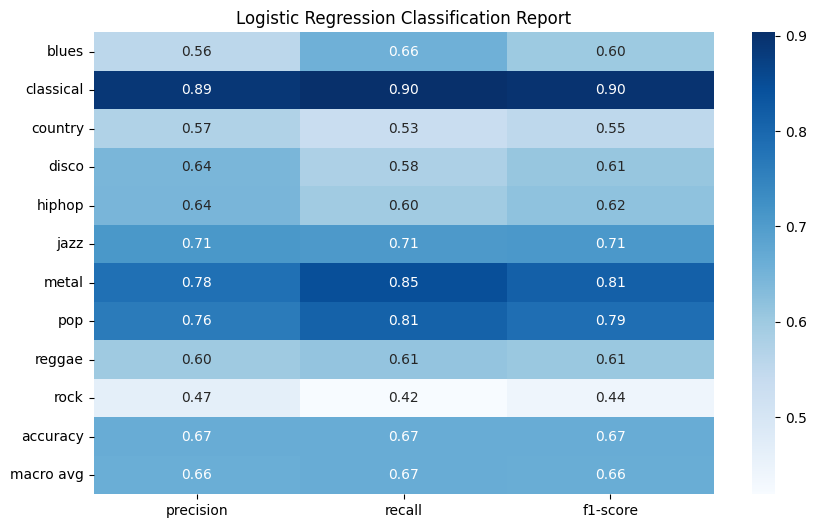

In [199]:
# Transform classification report into DataFrame
lr_report_df = pd.DataFrame(lr_report).transpose()

# Plotting the classification report
plt.figure(figsize=(10, 6))
sns.heatmap(data=lr_report_df.iloc[:-1, :].drop(columns=['support']), annot=True, cmap='Blues', fmt='.2f')
plt.title('Logistic Regression Classification Report')
plt.show()

Confusion Matrix for Logistic Regression

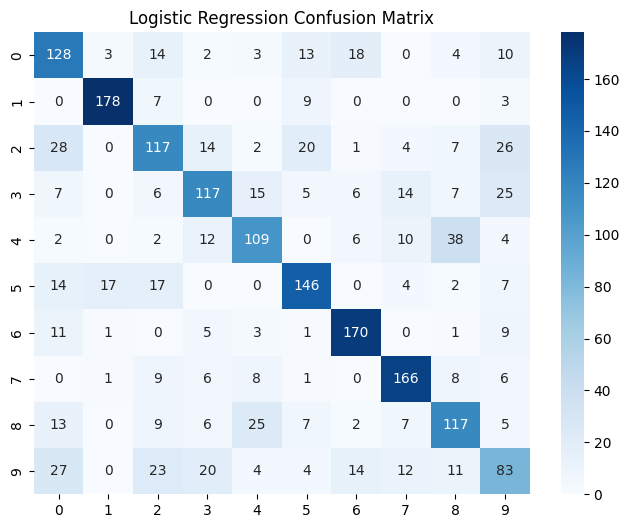

In [200]:
# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_lr_test), annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

#### Implementing Artificial Neural Networks

Encoding the target values for application of ANN

In [201]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)

Applying the model with the hidden layers with different number of neurons

In [202]:
model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(10, activation='softmax')
])

In [203]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Saving the Weights & Bias of the trained model in genre_classifier.keras file for ease of computation

In [204]:
try :
    class History():
        def __init__(self, history):
            self.history = history
    model = (load_model('genre_classifier.keras'))
    with open('model_history.pkl', 'rb') as file:
        loaded_history = pickle.load(file)
    history = History(loaded_history)
    
        
except:
    history = model.fit(X_train, y_train, epochs=70, validation_data=(X_test, y_test), verbose=0)
    with open('model_history.pkl', 'wb') as file:
        pickle.dump(history.history, file)

In [205]:
model.save('genre_classifier.keras')

Plotting the Loss Curve with epochs

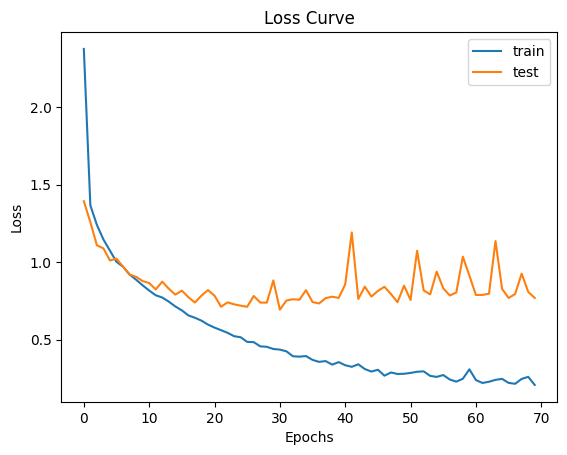

In [206]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Plotting the Accuracy Curve with epochs

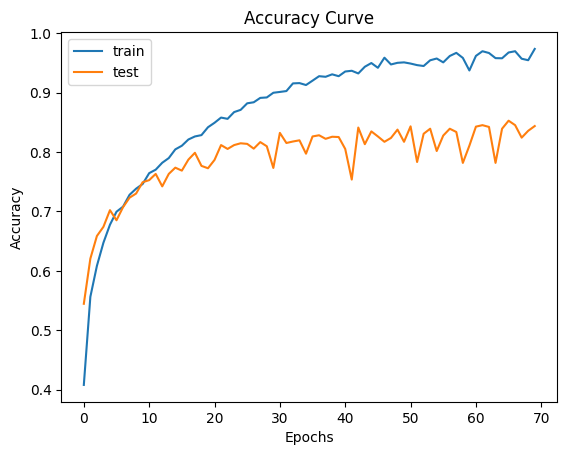

In [207]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Function to predict the Genre of audio

In [208]:
def predictANN(data):
    return encoder.classes_[np.argmax(model.predict(data), axis=1)]

Computing the train & test accuracy

In [209]:
y_test_pred_ANN = np.argmax(model.predict(X_test), axis=1)
ann_accuracy_test = accuracy_score(y_test_pred_ANN, y_test)
print("Test accuracy using ANN =", ann_accuracy_test)

63/63 [==============================] - 0s 2ms/step
Test accuracy using ANN = 0.8423423423423423


In [210]:
y_train_pred_ANN = np.argmax(model.predict(X_train), axis=1)
ann_accuracy_train = accuracy_score(y_train_pred_ANN, y_train)
print("Train accuracy using ANN =", ann_accuracy_train)

250/250 [==============================] - 0s 2ms/step
Train accuracy using ANN = 0.9730980980980981


Classification Report for Artificial Neural Networks

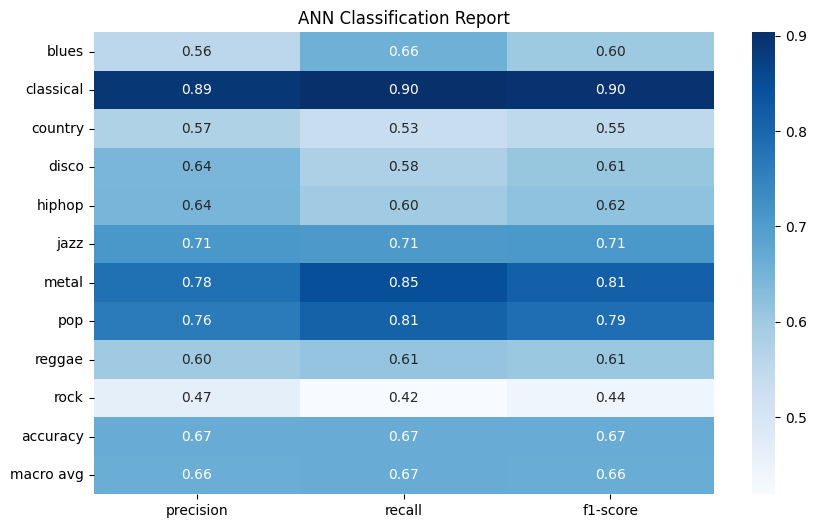

In [211]:
ANN_report = classification_report(y_test, y_test_pred_ANN, output_dict=True)

# Transform classification report into DataFrame
ANN_report_df = pd.DataFrame(ANN_report).transpose()

# Plotting the classification report
plt.figure(figsize=(10, 6))
sns.heatmap(data=lr_report_df.iloc[:-1, :].drop(columns=['support']), annot=True, cmap='Blues', fmt='.2f')
plt.title('ANN Classification Report')
plt.show()

Confusion Matrix for Artificial Neural Networks

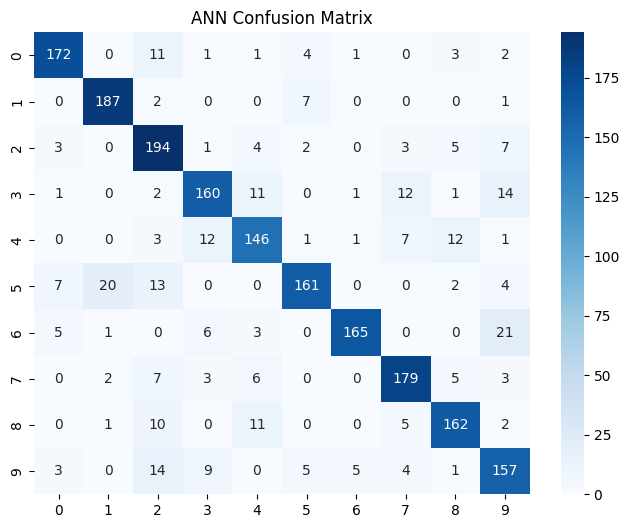

In [212]:
# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_test_pred_ANN), annot=True, fmt='d', cmap='Blues')
plt.title('ANN Confusion Matrix')
plt.show()

#### Comparing the train & test Accuracies of different models

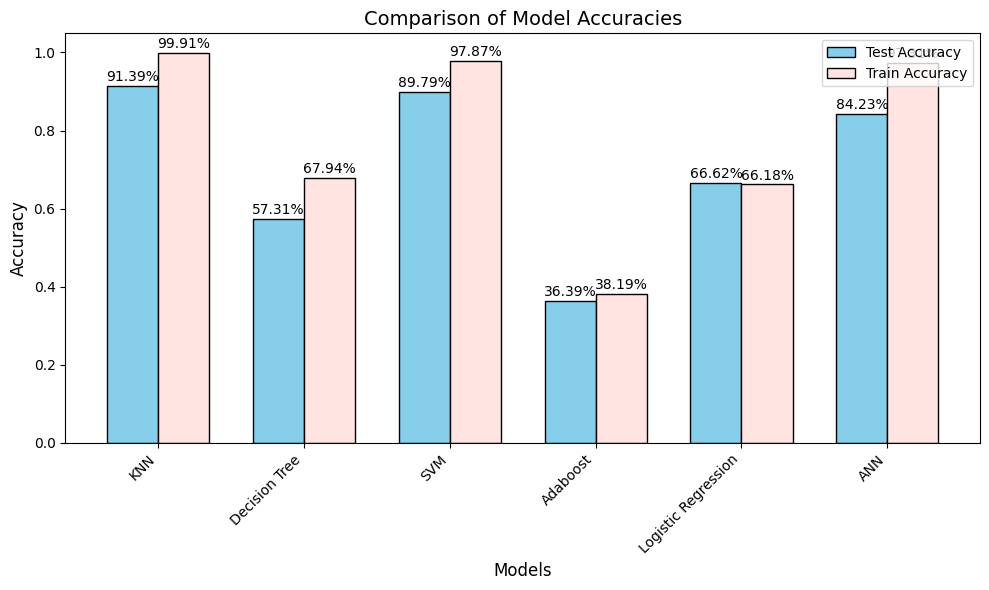

In [213]:
models = ['KNN', 'Decision Tree', 'SVM', 'Adaboost', 'Logistic Regression', 'ANN']

index = np.arange(len(models))
bar_width = 0.35

# Corresponding accuracies
test_accuracies = [knn_accuracy_test, dt_accuracy_test, svm_accuracy_test, adaboost_accuracy_test, lr_accuracy_test, ann_accuracy_test]
train_accuracies = [knn_accuracy_train, dt_accuracy_train, svm_accuracy_train, adaboost_accuracy_train, lr_accuracy_train, ann_accuracy_train]

# Creating the bar chart
plt.figure(figsize=(10, 6))

plt.bar(index, test_accuracies, bar_width, label='Test Accuracy', color="skyblue", edgecolor='black')
plt.bar(index + bar_width, train_accuracies, bar_width, label='Train Accuracy', color="mistyrose", edgecolor='black')

# Adding text labels
for i in range(len(index)):
    plt.text(i, test_accuracies[i] + 0.005, f'{test_accuracies[i]*100:.2f}%', ha='center', va='bottom', fontsize=10)
    plt.text(i + bar_width, train_accuracies[i] + 0.005, f'{train_accuracies[i]*100:.2f}%', ha='center', va='bottom', fontsize=10)

plt.xlabel('Models', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Comparison of Model Accuracies', fontsize=14)
plt.xticks(index + bar_width / 2, models, rotation=45, ha='right', fontsize=10)
plt.legend()
plt.tight_layout()
plt.show()

## Functions for inferring Genres of new audio data

Implementation of a function to compute the audio features and apply PCA to reduce the number of features

In [214]:
path = "Data/genres_original/blues/blues.00000.wav"

def music_transform(path):

    if ".mp3" in path:
        y, sr = sf.read(path)

        if len(y.shape) > 1:
            y = librosa.to_mono(y.T)

    y, sr = librosa.load(path)

    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)

    mfccs_mean = np.mean(mfccs,axis = 1)
    mfccs_var = np.var(mfccs, axis = 1)
    rms = librosa.feature.rms(y=y)
    chromagram = librosa.feature.chroma_stft(y=y, sr=sr)
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y)
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    y_harmonic, y_percussive = librosa.effects.hpss(y)
    tempo = librosa.beat.tempo(y=y, sr=sr)

    data_array = []
    features = [chromagram,rms,spectral_centroid,spectral_bandwidth,spectral_rolloff,zero_crossing_rate,y_harmonic,y_percussive]

    for i in features:
        data_array.append(np.mean(i))
        data_array.append(np.var(i))

    data_array.append(tempo)

    for i in range(20):
        data_array.append(mfccs_mean[i])
        data_array.append(mfccs_var[i])

    music_data = pd.DataFrame(np.array(data_array).reshape(1,57),columns = ['chroma_stft_mean', 'chroma_stft_var', 'rms_mean', 'rms_var',
       'spectral_centroid_mean', 'spectral_centroid_var',
       'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean',
       'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var',
       'harmony_mean', 'harmony_var', 'perceptr_mean', 'perceptr_var', 'tempo',
       'mfcc1_mean', 'mfcc1_var', 'mfcc2_mean', 'mfcc2_var', 'mfcc3_mean',
       'mfcc3_var', 'mfcc4_mean', 'mfcc4_var', 'mfcc5_mean', 'mfcc5_var',
       'mfcc6_mean', 'mfcc6_var', 'mfcc7_mean', 'mfcc7_var', 'mfcc8_mean',
       'mfcc8_var', 'mfcc9_mean', 'mfcc9_var', 'mfcc10_mean', 'mfcc10_var',
       'mfcc11_mean', 'mfcc11_var', 'mfcc12_mean', 'mfcc12_var', 'mfcc13_mean',
       'mfcc13_var', 'mfcc14_mean', 'mfcc14_var', 'mfcc15_mean', 'mfcc15_var',
       'mfcc16_mean', 'mfcc16_var', 'mfcc17_mean', 'mfcc17_var', 'mfcc18_mean',
       'mfcc18_var', 'mfcc19_mean', 'mfcc19_var', 'mfcc20_mean', 'mfcc20_var'])
    scaled_data_music = scaler.transform(music_data)

    scaled_dataframe = pd.DataFrame(scaled_data_music, columns = music_data.columns)

    musicpca_components = pca.transform(scaled_dataframe)

    music_pca = pd.DataFrame(musicpca_components)
    return music_pca



Function which takes path of audio file and name of classifier to predict the Genre

In [215]:
def modelPrediction(path, classifier = "KNN"):

    music_data = music_transform(path)

    if classifier == "KNN":
        return knn_best.predict(music_data)
    elif classifier == "Decision Tree":
        return dt_best.predict(music_data)
    elif classifier == "SVM":
        return svm_best.predict(music_data)
    elif classifier == "Adaboost":
        return adaboost_best.predict(music_data)
    elif classifier == "Logistic Regression":
        return lr_best.predict(music_data)
    elif classifier == "ANN":
        return predictANN(music_data)
    else:
        return "Model Not Found"

In [216]:
print("According to KNN the audio is", modelPrediction(path,"KNN"))
print("According to Decision Tree the audio is", modelPrediction(path,"Decision Tree"))
print("According to SVM the audio is", modelPrediction(path,"SVM"))
print("According to Adaboost the audio is", modelPrediction(path,"Adaboost"))
print("According to Logistic Regression the audio is", modelPrediction(path,"Logistic Regression"))
print("According to ANN the audio is", modelPrediction(path,"ANN"))

According to KNN the audio is ['blues']
According to Decision Tree the audio is ['reggae']
According to SVM the audio is ['blues']
According to Adaboost the audio is ['reggae']
According to Logistic Regression the audio is ['blues']
1/1 [==============================] - 0s 19ms/step
According to ANN the audio is ['blues']
